In [1]:
import pandas as pd

df = pd.read_parquet("active_labeled.parquet")
df

,filepath,label
0,data/oxford-iiit-pet/20/Maine_Coon_100.jpg,maine_coon
1,data/oxford-iiit-pet/20/Maine_Coon_136.jpg,maine_coon
2,data/oxford-iiit-pet/20/Maine_Coon_131.jpg,maine_coon
3,data/oxford-iiit-pet/20/Maine_Coon_201.jpg,maine_coon
4,data/oxford-iiit-pet/20/Maine_Coon_171.jpg,maine_coon
...,...,...
607,data/oxford-iiit-pet/6/Birman_187.jpg,birman
608,data/oxford-iiit-pet/20/Maine_Coon_193.jpg,maine_coon
609,data/oxford-iiit-pet/9/British_Shorthair_149.jpg,british_shorthair
610,data/oxford-iiit-pet/6/Birman_153.jpg,birman


In [2]:
import timm
timm.list_models("vit*")

['vit_base_mci_224',
 'vit_base_patch8_224',
 'vit_base_patch14_dinov2',
 'vit_base_patch14_reg4_dinov2',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_384',
 'vit_base_patch16_clip_224',
 'vit_base_patch16_clip_384',
 'vit_base_patch16_clip_quickgelu_224',
 'vit_base_patch16_gap_224',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_plus_clip_240',
 'vit_base_patch16_reg4_gap_256',
 'vit_base_patch16_rope_reg1_gap_256',
 'vit_base_patch16_rpn_224',
 'vit_base_patch16_siglip_224',
 'vit_base_patch16_siglip_256',
 'vit_base_patch16_siglip_384',
 'vit_base_patch16_siglip_512',
 'vit_base_patch16_siglip_gap_224',
 'vit_base_patch16_siglip_gap_256',
 'vit_base_patch16_siglip_gap_384',
 'vit_base_patch16_siglip_gap_512',
 'vit_base_patch16_xp_224',
 'vit_base_patch32_224',
 'vit_base_patch32_384',
 'vit_base_patch32_clip_224',
 'vit_base_patch32_clip_256',
 'vit_base_patch32_clip_384',
 'vit_base_patch32_clip_448',
 'vit_base_patch32

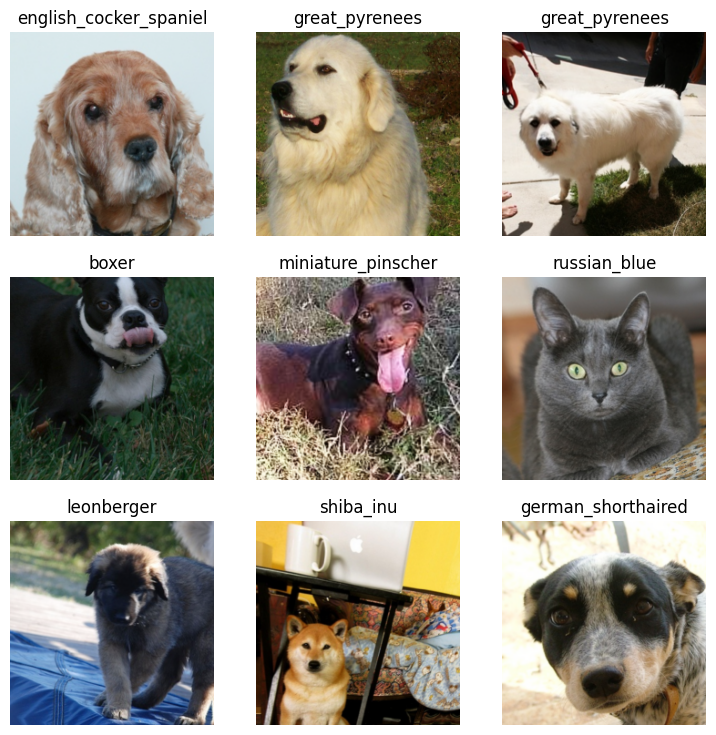

In [3]:
from fastai.vision.all import *

base_path = "."
dls = ImageDataLoaders.from_df(
    df,
    path=base_path,
    valid_pct=0.2,
    fn_col="filepath",
    label_col="label",
    bs=16,
    item_tfms=Resize(480),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
)

dls.show_batch()

/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, m

SuggestedLRs(valley=0.001737800776027143, slide=0.0030199517495930195)

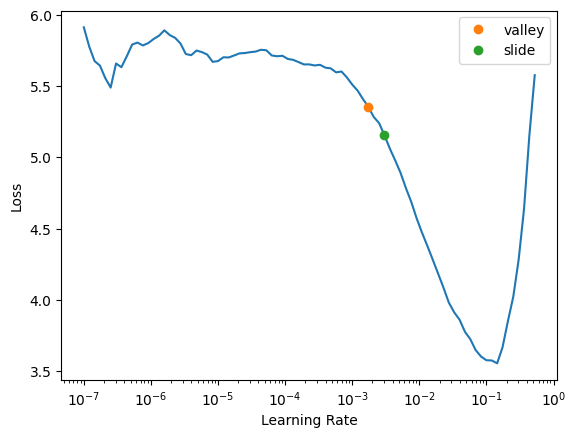

In [4]:
learn = vision_learner(dls, "vit_base_patch16_224", metrics=accuracy).to_fp16()
learn.lr_find(suggest_funcs=(valley, slide))

epoch,train_loss,valid_loss,accuracy,time
0,2.971728,0.969338,0.729508,00:03


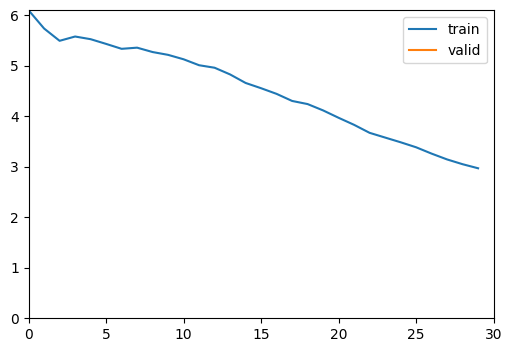

epoch,train_loss,valid_loss,accuracy,time
0,0.662392,0.789875,0.786885,00:04
1,0.524273,0.598956,0.819672,00:04
2,0.442025,1.008965,0.745902,00:04
3,0.416441,1.146264,0.811475,00:04
4,0.321999,1.108029,0.803279,00:04
5,0.229976,0.908265,0.811475,00:04
6,0.161248,0.986895,0.827869,00:04
7,0.112496,0.942532,0.827869,00:04
8,0.081626,0.894352,0.827869,00:04
9,0.055184,0.895845,0.827869,00:04


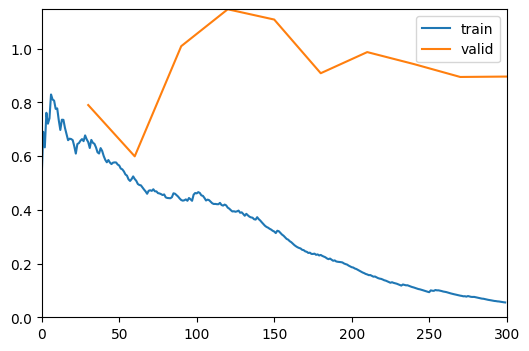

In [5]:
learn.fine_tune(10, base_lr=5e-3, freeze_epochs=1, cbs=ShowGraphCallback())


In [6]:
test_df = pd.read_parquet("data/oxford-iiit-pet/evaluation_samples.parquet")
test_df

,filepath,label
0,data/oxford-iiit-pet/22/newfoundland_31.jpg,newfoundland
1,data/oxford-iiit-pet/25/pug_57.jpg,pug
2,data/oxford-iiit-pet/1/american_bulldog_80.jpg,american_bulldog
3,data/oxford-iiit-pet/15/great_pyrenees_22.jpg,great_pyrenees
4,data/oxford-iiit-pet/16/havanese_97.jpg,havanese
...,...,...
3664,data/oxford-iiit-pet/10/chihuahua_91.jpg,chihuahua
3665,data/oxford-iiit-pet/17/japanese_chin_83.jpg,japanese_chin
3666,data/oxford-iiit-pet/28/saint_bernard_88.jpg,saint_bernard
3667,data/oxford-iiit-pet/21/miniature_pinscher_32.jpg,miniature_pinscher


In [12]:
filepaths = test_df["filepath"].tolist()
labels = test_df["label"].tolist()
test_dl = dls.test_dl(filepaths, bs=16)
preds, _, cls_preds = learn.get_preds(dl=test_dl, with_decoded=True)

results = pd.DataFrame(
    {
        "filepath": filepaths,
        "label": labels,
        "pred_label": [learn.dls.vocab[i] for i in cls_preds.numpy()],
    }
)

accuracy = float((results["label"] == results["pred_label"]).mean())
accuracy


/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


0.9070591441809758

In [14]:
probs, targets = learn.tta(dl=test_dl)
probs



/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


tensor([[9.7348e-09, 3.4489e-07, 5.0512e-08,  ..., 5.7763e-07, 3.6665e-08,
         1.3628e-08],
        [4.5266e-07, 3.8665e-08, 5.1546e-08,  ..., 1.6257e-05, 6.9420e-08,
         1.7740e-06],
        [1.9398e-05, 9.7949e-01, 5.7652e-03,  ..., 3.6506e-03, 3.1294e-05,
         5.4315e-04],
        ...,
        [2.0659e-07, 8.7994e-07, 2.4873e-06,  ..., 1.0168e-07, 1.4604e-05,
         1.4369e-07],
        [1.3305e-07, 5.0808e-08, 2.0900e-07,  ..., 9.2706e-08, 3.8884e-07,
         2.7861e-06],
        [1.4278e-06, 9.0570e-07, 1.4902e-07,  ..., 2.5266e-07, 9.6976e-07,
         2.6712e-06]])

In [15]:
probs.shape

torch.Size([3669, 37])

In [16]:
pred_indices = torch.argmax(probs, dim=1)
pred_indices

tensor([22, 25,  1,  ..., 28, 21, 10])

In [17]:
pred_indices.shape

torch.Size([3669])

In [18]:
pred_labels = [learn.dls.vocab[i] for i in pred_indices.numpy()]
pred_labels

results = pd.DataFrame(
    {
        "filepath": filepaths,
        "label": labels,
        "pred_label": pred_labels,
    }
)
results

,filepath,label,pred_label
0,data/oxford-iiit-pet/22/newfoundland_31.jpg,newfoundland,newfoundland
1,data/oxford-iiit-pet/25/pug_57.jpg,pug,pug
2,data/oxford-iiit-pet/1/american_bulldog_80.jpg,american_bulldog,american_bulldog
3,data/oxford-iiit-pet/15/great_pyrenees_22.jpg,great_pyrenees,great_pyrenees
4,data/oxford-iiit-pet/16/havanese_97.jpg,havanese,havanese
...,...,...,...
3664,data/oxford-iiit-pet/10/chihuahua_91.jpg,chihuahua,chihuahua
3665,data/oxford-iiit-pet/17/japanese_chin_83.jpg,japanese_chin,japanese_chin
3666,data/oxford-iiit-pet/28/saint_bernard_88.jpg,saint_bernard,saint_bernard
3667,data/oxford-iiit-pet/21/miniature_pinscher_32.jpg,miniature_pinscher,miniature_pinscher


Small bump in accuracy with TTA.

In [19]:
accuracy = float((results["label"] == results["pred_label"]).mean())
accuracy

0.9116925592804579